Test Accuracy: 0.5405

Classification Report:
               precision    recall  f1-score   support

           A       0.53      0.60      0.57       554
           D       0.32      0.26      0.29       462
           H       0.64      0.65      0.64       860

    accuracy                           0.54      1876
   macro avg       0.50      0.50      0.50      1876
weighted avg       0.53      0.54      0.53      1876



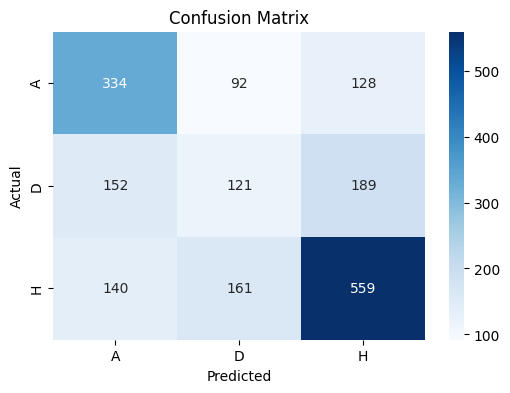

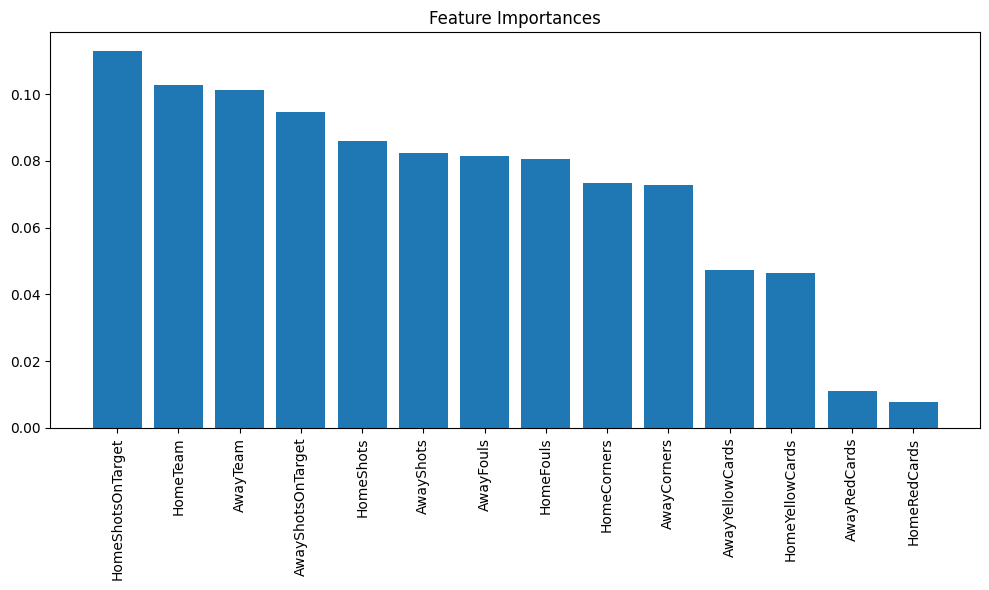

In [5]:
# ===============================
# Match Winner Prediction + SMOTE + Hyperparameters
# ===============================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
file_path = "/content/every_match.csv"   # update path if needed
df = pd.read_csv(file_path)

# --- Data Cleaning ---
df = df.dropna()
df = df.drop_duplicates()

# 2. Target column (encode to numbers)
y = df["FullTimeResult"]
le_target = LabelEncoder()
y = le_target.fit_transform(y)   # H/A/D -> 0/1/2

# 3. Drop leakage + irrelevant columns
leakage_cols = [
    "FullTimeHomeGoals", "FullTimeAwayGoals",
    "HalfTimeHomeGoals", "HalfTimeAwayGoals", "HalfTimeResult"
]
X = df.drop(columns=["Season", "MatchDate", "FullTimeResult"] + leakage_cols)

# 4. Encode categorical features
for col in X.columns:
    if X[col].dtype == "object":
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# 5. Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Build pipeline with SMOTE + RandomForest (best params found earlier)
pipeline = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    ))
])

# 7. Train model
pipeline.fit(X_train, y_train)

# 8. Predictions
y_pred = pipeline.predict(X_test)

# 9. Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))

# 10. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 11. Feature Importances
model = pipeline.named_steps["clf"]
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()
